## Code Modules & Functions

In [1]:
import numpy as np,pandas as pd,pylab as pl
import h5py,tensorflow as tf
from tensorflow import image as timg
import tensorflow.keras.layers as tfkl
import tensorflow.keras.applications as tfka

In [2]:
def resize_info(x_train,y_train,
                x_test,y_test,pixels):
    x_train=np.array(timg.resize(x_train,[pixels,pixels]))
    x_test=np.array(timg.resize(x_test,[pixels,pixels]))
    N=len(y_train); shuffle_ids=np.arange(N)
    np.random.RandomState(12).shuffle(shuffle_ids)
    x_train,y_train=x_train[shuffle_ids],y_train[shuffle_ids]
    N=len(y_test); shuffle_ids=np.arange(N)
    np.random.RandomState(23).shuffle(shuffle_ids)
    x_test,y_test=x_test[shuffle_ids],y_test[shuffle_ids]
    n=int(len(x_test)/2)
    x_valid,y_valid=x_test[:n],y_test[:n]
    x_test,y_test=x_test[n:],y_test[n:]
    df=pd.DataFrame([[x_train.shape,x_valid.shape,x_test.shape],
                     [x_train.dtype,x_valid.dtype,x_test.dtype],
                     [y_train.shape,y_valid.shape,y_test.shape],
                     [y_train.dtype,y_valid.dtype,y_test.dtype]],
                    columns=['train','valid','test'],
                    index=['image shape','image type',
                           'label shape','label type'])
    display(df)    
    return [[x_train,x_valid,x_test],
            [y_train,y_valid,y_test]]
def display_examples(x,y):
    n=np.random.randint(1,50)
    fig=pl.figure(figsize=(11,4))
    for i in range(n,n+5):
        ax=fig.add_subplot(1,5,i-n+1,\
        xticks=[],yticks=[],title=y[i])
        ax.imshow(x[i]); 
    pl.show()

## Data

In [3]:
pixels=64
fpath='../input/tf-cats-vs-dogs/'
f='CatDogImages.h5'
f=h5py.File(fpath+f,'r')
keys=list(f.keys()); print(keys)
x_test=np.array(f[keys[0]])
y_test=np.array(f[keys[1]]).reshape(-1)
x_train=np.array(f[keys[2]])
y_train=np.array(f[keys[3]]).reshape(-1)
[[x_train,x_valid,x_test],
 [y_train,y_valid,y_test]]=\
resize_info(x_train,y_train,x_test,y_test,pixels)

['test_images', 'test_labels', 'train_images', 'train_labels']


,train,valid,test
image shape,"(18610, 64, 64, 3)","(2326, 64, 64, 3)","(2326, 64, 64, 3)"
image type,float32,float32,float32
label shape,"(18610,)","(2326,)","(2326,)"
label type,int32,int32,int32


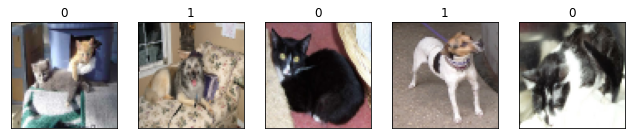

In [4]:
display_examples(x_valid,y_valid)

## VGG16

In [5]:
def VGG16L(pixels):
    base_model=tfka.VGG16(include_top=False,
                          weights='imagenet',
                          input_shape=(pixels,pixels,3))
    x=base_model.output
    x=tfkl.GlobalAveragePooling2D()(x)
    x=tfkl.Dense(1024)(x)
    x=tfkl.LeakyReLU(alpha=.02)(x)
    y=tfkl.Dense(1,activation=tf.nn.sigmoid)(x)
    model=tf.keras.Model(inputs=base_model.input,outputs=y)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [6]:
fw='weights.best.hdf5'
def cb(fw):
    early_stopping=tf.keras.callbacks\
    .EarlyStopping(monitor='val_loss',patience=20,verbose=2)
    checkpointer=tf.keras.callbacks\
    .ModelCheckpoint(filepath=fw,save_best_only=True,verbose=2)
    lr_reduction=tf.keras.callbacks\
    .ReduceLROnPlateau(monitor='val_loss',verbose=2,
                       patience=5,factor=.8)
    return [checkpointer,early_stopping,lr_reduction]
def history_plot(fit_history):
    pl.figure(figsize=(12,10)); pl.subplot(211)
    keys=list(fit_history.history.keys())[0:4]
    pl.plot(fit_history.history[keys[0]],
            color='slategray',label='train')
    pl.plot(fit_history.history[keys[2]],
            color='#4876ff',label='valid')
    pl.xlabel("Epochs"); pl.ylabel("Loss")
    pl.legend(); pl.grid()
    pl.title('Loss Function')     
    pl.subplot(212)
    pl.plot(fit_history.history[keys[1]],
            color='slategray',label='train')
    pl.plot(fit_history.history[keys[3]],
            color='#4876ff',label='valid')
    pl.xlabel("Epochs"); pl.ylabel("Accuracy")    
    pl.legend(); pl.grid()
    pl.title('Accuracy'); pl.show()

In [7]:
model=VGG16L(pixels)
history=model.fit(x=x_train,y=y_train,
                  batch_size=128,epochs=20,
                  callbacks=cb(fw),
                  validation_data=(x_valid,y_valid))

58892288/58889256 [==============================] - 0s 0us/step
Epoch 1/20
146/146 [==============================] - ETA: 0s - loss: 0.8032 - accuracy: 0.5432
Epoch 00001: val_loss improved from inf to 0.65778, saving model to weights.best.hdf5
146/146 [==============================] - 14s 94ms/step - loss: 0.8032 - accuracy: 0.5432 - val_loss: 0.6578 - val_accuracy: 0.6139 - lr: 0.0010
Epoch 2/20
145/146 [============================>.] - ETA: 0s - loss: 0.6032 - accuracy: 0.6728
Epoch 00002: val_loss improved from 0.65778 to 0.48369, saving model to weights.best.hdf5
146/146 [==============================] - 13s 88ms/step - loss: 0.6030 - accuracy: 0.6730 - val_loss: 0.4837 - val_accuracy: 0.7704 - lr: 0.0010
Epoch 3/20
145/146 [============================>.] - ETA: 0s - loss: 0.4130 - accuracy: 0.8106
Epoch 00003: val_loss improved from 0.48369 to 0.35802, saving model to weights.best.hdf5
146/146 [==============================] - 13s 88ms/step - loss: 0.4128 - accuracy: 0.810

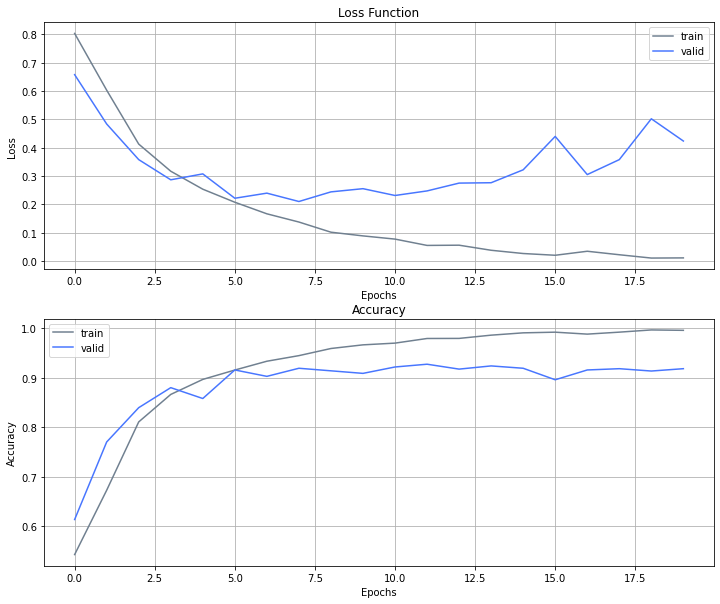

In [8]:
history_plot(history)

In [9]:
model.load_weights(fw)
model.evaluate(x_test,y_test)

73/73 [==============================] - 1s 11ms/step - loss: 0.2235 - accuracy: 0.9149


[0.22352325916290283, 0.914875328540802]